### 1. Import Library

In [6]:
# !pip install -r requirements.txt

In [7]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import random
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [8]:
# 난수 생성 고정
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### 2. Load Train Data & Test Data

In [9]:
# 데이터 경로 설정
DATA_PATH = Path("./data")

In [10]:
train_data = pd.read_csv(DATA_PATH / "train.csv")
test_data = pd.read_csv(DATA_PATH / "test.csv")

In [11]:
# 필요 피처 선택
non_numeric_cols = ["faultNumber", "simulationRun", "sample"]
use_cols = train_data.columns.difference(non_numeric_cols)

X_train = train_data[use_cols]
X_test = test_data[use_cols]

In [12]:
print(len(X_train.columns))
print(len(X_test.columns))

52
52


In [13]:
# 필요한 라이브러리 임포트 
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from torch.utils.data import DataLoader, TensorDataset 
import torch

# 데이터 스케일러 인스턴스 생성(데이터 표준화)
## 어떤 스케일러를 적용해야하는가?
# scaler = MinMaxScaler()
scaler = RobustScaler() 
# 학습 데이터셋에 대해 fit과 transform 수행: train 기준 정보 계산 및 데이터 변환
X_train_scaled = scaler.fit_transform(X_train) 
# 테스트 데이터셋에 대해서는 transform만 수행: 학습 데이터셋의 기준 정보를 사용하여 데이터 변환
X_test_scaled = scaler.transform(X_test)  

# PyTorch Tensor로 변환 
X_train_tensor = torch.FloatTensor(X_train_scaled) 
X_test_tensor = torch.FloatTensor(X_test_scaled)  

# DataLoader 설정 
train_dataset = TensorDataset(X_train_tensor, X_train_tensor) # 입력과 타겟이 같음 
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, X_test_tensor) # 입력과 타겟이 같음 
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [14]:
print(len(train_dataset))
print(len(test_dataset))

250000
710400


In [15]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for data in test_loader:
    inputs = data[0]
    break

print(inputs.shape)

torch.Size([1, 52])


### 3. Autoencoder 구현

In [16]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 인코더 구성
        ## 적절한 차원의 차수는?
        ## trial-1: 52 > 32 > 16
        ## trial-2: 52 > 32 > 16 > 8
        ## trial-3: 52 > 26 > 13 > 6 > 3
        self.encoder = nn.Sequential(
            nn.Linear(52, 26), # 입력 차원 52에서 낮은 차수의 중간 차원 32로 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(26, 13), # 중간 차원 32에서 특징 차원 16으로 더 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(13, 6), # 중간 차원 32에서 특징 차원 16으로 더 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(6, 3), # 중간 차원 32에서 특징 차원 16으로 더 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
        )
        # 디코더 구성
        self.decoder = nn.Sequential(
            nn.Linear(3, 6), # 중간 차원 32에서 특징 차원 16으로 더 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(6, 13), # 중간 차원 32에서 특징 차원 16으로 더 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(13, 26), # 특징 차원 16에서 중간 차원 32으로 확장
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(26, 52), # 중간 차원 32에서 원본 차원인 55로 복원
            nn.Sigmoid() # 출력을 0과 1 사이로 조정
        )

    def forward(self, x):
        x = self.encoder(x) # 인코딩
        x = self.decoder(x) # 디코딩
        return x

### 4. Model Traning

In [18]:
model = Autoencoder()
criterion = nn.MSELoss() # MSE: Mean Squared Error 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam optimizer

In [ ]:
for epoch in range(100):
    for data in train_loader:
        inputs = data[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

In [19]:
model_name = "exp2-4layers"
torch.save(model.state_dict(), f"./model_{model_name}.pt")

### 5. Model Inference

In [20]:
model.load_state_dict(torch.load("model_exp2-4layers.pt"))

/tmp/ipykernel_666615/2834326068.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_exp2-4layers.pt"))


<All keys matched successfully>

In [21]:
model.eval()

batch_size = len(train_dataset)
infer_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for data in infer_train_loader:
        inputs = data[0]
        outputs = model(inputs)

In [22]:
 # reconstruction error 계산 
train_reconstruction_errors = torch.mean((outputs - inputs) ** 2, axis=1)  #MSE
print(train_reconstruction_errors)

df_train_reconstruction_errors = pd.DataFrame(train_reconstruction_errors.detach().numpy(), columns=["error"])
print(type(df_train_reconstruction_errors))
print(df_train_reconstruction_errors.shape)

max_error = df_train_reconstruction_errors["error"].max()
print(type(max_error))
print(max_error)

tensor([0.3209, 0.4317, 0.4800,  ..., 0.5739, 0.8435, 0.8981])
<class 'pandas.core.frame.DataFrame'>
(250000, 1)
<class 'float'>
2.6863744258880615


In [23]:
df_train_reconstruction_errors.describe()

,error
count,250000.000000
mean,0.805823
std,0.220618
min,0.213303
25%,0.650729
50%,0.775014
75%,0.926082
max,2.686374


In [24]:
train_reconstruction_errors

tensor([0.3209, 0.4317, 0.4800,  ..., 0.5739, 0.8435, 0.8981])

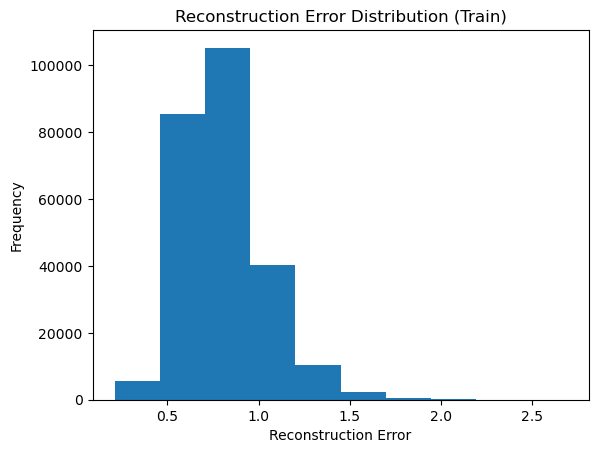

In [27]:
# reconstruction error 히스토그램 시각화 
plt.hist(train_reconstruction_errors.detach().numpy(), bins=10) 
plt.xlabel('Reconstruction Error') 
plt.ylabel('Frequency') 
plt.title('Reconstruction Error Distribution (Train)')

plt.show()

In [26]:
model.eval()

batch_size = len(test_dataset)
infer_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for data in infer_test_loader:
        inputs = data[0]
        outputs = model(inputs)

In [28]:
# reconstruction error 계산 
test_reconstruction_errors = torch.mean((outputs - inputs) ** 2, axis=1)  #MSE
print(test_reconstruction_errors)

df_test_reconstruction_errors = pd.DataFrame(test_reconstruction_errors.detach().numpy(), columns=["error"])
print(type(df_test_reconstruction_errors))
print(df_test_reconstruction_errors.shape)

tensor([3.2515e-01, 4.4277e-01, 6.4880e-01,  ..., 4.6904e+02, 4.7019e+02,
        4.7019e+02])
<class 'pandas.core.frame.DataFrame'>
(710400, 1)


In [29]:
df_test_reconstruction_errors.describe()

,error
count,710400.000000
mean,14.244827
std,71.843918
min,0.232024
25%,0.689279
50%,0.845805
75%,1.134598
max,658.855042


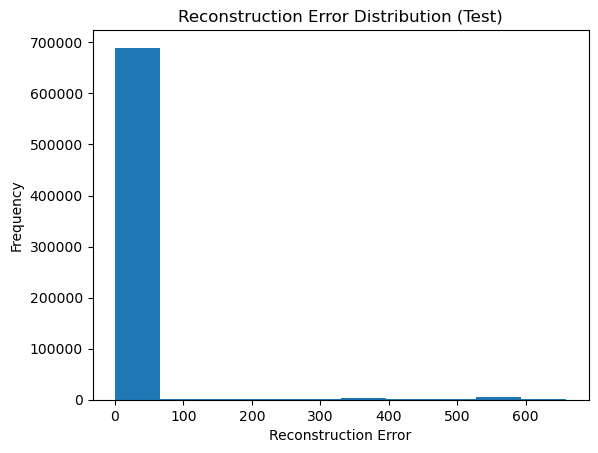

In [31]:
# reconstruction error 히스토그램 시각화 
plt.hist(test_reconstruction_errors.detach().numpy(), bins=10) 
plt.xlabel('Reconstruction Error') 
plt.ylabel('Frequency') 
plt.title('Reconstruction Error Distribution (Test)')

plt.show()

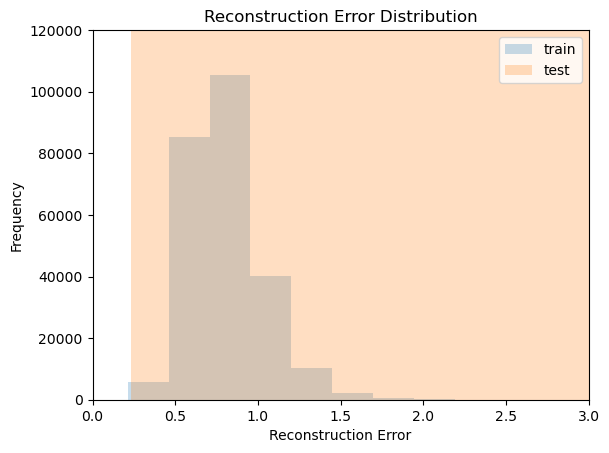

In [38]:
# reconstruction error 히스토그램 시각화
plt.hist(train_reconstruction_errors.detach().numpy(), alpha=0.25, label="train", bins=10)
plt.hist(test_reconstruction_errors.detach().numpy(), alpha=0.25, label="test", bins=10)
plt.xlim((0, 3))
plt.ylim((0, 120000))
plt.xlabel('Reconstruction Error') 
plt.ylabel('Frequency') 
plt.title('Reconstruction Error Distribution')
plt.legend()

plt.show()

In [42]:
# threshold = max_error + max_error * 0.1

In [43]:
# threshold = np.mean(df_train_reconstruction_errors["error"]) + np.std(df_train_reconstruction_errors["error"])

In [44]:
threshold = np.mean(df_train_reconstruction_errors["error"]) + 3 * np.std(df_train_reconstruction_errors["error"])
print("threshold: ", threshold)

threshold:  0.8830099254846573


In [45]:
df = df_test_reconstruction_errors.copy()

df["faultNumber"] = 0
df.loc[df["error"] > threshold, "faultNumber"] = 1

df_output = df.drop("error", axis=1)

In [46]:
df_output.value_counts()

faultNumber
0              579155
1              131245
Name: count, dtype: int64

In [47]:
from datetime import datetime

# CSV 파일로 저장
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"output_{current_time}.csv"
df_output.to_csv(filename)

##### 기록
1) input_dims=52, num_layers=2, hidden_dims=[32, 16], train_batch_size=64, epoch=20
    - threshold = max_error + max_error (0.016887)
        - 0.6614 (F1 Score)
        - 0.8359 (Accuracy)
2) input_dims=52, num_layers=2, hidden_dims=[32, 16], train_batch_size=64, epoch=20
    - threshold = max_error + max_error * 0.1 (0.016769 + (0.016769) * 0.1)
        - 0.6665
        - 0.7846
3) input_dims=52, num_layers=3, hidden_dims=[32, 16, 8], train_batch_size=64, epoch=20
    - threshold = max_error + max_error * 0.2 (0.017843 + (0.017843) * 0.2)
        - 0.6626
        - 0.7822
4) input_dims=52, num_layers=3, hidden_dims=[32, 16, 8], train_batch_size=64, epoch=20
    - threshold = np.mean(df_train_reconstruction_errors["error"]) + np.std(df_train_reconstruction_errors["error"]) (0.008588183671236038)
5) input_dims=52, num_layers=3, hidden_dims=[32, 16, 8], train_batch_size=128, epoch=20
    - threshold = np.mean(df_train_reconstruction_errors["error"]) + np.std(df_train_reconstruction_errors["error"]) (0.01129639009013772)
        - 0.6689
        - 0.7897
6) input_dims=52, num_layers=3, hidden_dims=[32, 16, 8], train_batch_size=256, epoch=20
    - threshold = np.mean(df_train_reconstruction_errors["error"]) + np.std(df_train_reconstruction_errors["error"]) (0.5062470883131027)
7) input_dims=52, num_layers=3, hidden_dims=[32, 16, 8], train_batch_size=256, epoch=100
    - threshold = np.mean(df_train_reconstruction_errors["error"]) + 3 * np.std(df_train_reconstruction_errors["error"]) (0.7653539180755615)
        - 0.6969
        - 0.8448
8) input_dims=52, num_layers=4, hidden_dims=[26, 13, 6, 3], train_batch_size=256, epoch=100
    - threshold = np.mean(df_train_reconstruction_errors["error"]) + 3 * np.std(df_train_reconstruction_errors["error"]) (0.8830099254846573)
